In [1]:
import osmnx as ox
import networkx as nx
import pandas as pd
import numpy as np
from geopy.distance import geodesic

In [1]:



# Download the street network of Aalborg
def download_street_network():
    return ox.graph_from_place('Aalborg Municipality, Denmark', network_type='drive', simplify=True, retain_all=False)

# Function to calculate the closest distance from a node to a POI (handles points and polygons)
def calculate_closest_poi_distance(node, pois, G):
    node_point = (G.nodes[node]['y'], G.nodes[node]['x'])  # Node's lat/lon
    closest_distance = np.inf
    for poi in pois.itertuples():
        if poi.geometry.geom_type == 'Point':  # If it's a point
            poi_point = (poi.geometry.y, poi.geometry.x)
        elif poi.geometry.geom_type == 'Polygon':  # If it's a polygon
            poi_point = (poi.geometry.centroid.y, poi.geometry.centroid.x)  # Use the centroid
        else:
            continue  # Skip if not a valid geometry type
        
        distance = geodesic(node_point, poi_point).meters
        if distance < closest_distance:
            closest_distance = distance
    return closest_distance

# Function to add edge attributes
def add_edge_attributes(G):
    for u, v, k, data in G.edges(keys=True, data=True):
        # Add speed limit (maxspeed)
        maxspeed = data.get('maxspeed', 'None')
        if isinstance(maxspeed, list):
            maxspeed = maxspeed[0]
        data['allowed_speed'] = maxspeed
        
        # Add number of lanes
        lanes = data.get('lanes', 'None')
        data['lanes'] = lanes
        
        # Add surface type
        surface = data.get('surface', 'None')
        data['surface_type'] = surface
        
        # Add bridge and tunnel information
        data['is_bridge'] = data.get('bridge', 'False') == 'True'
        data['is_tunnel'] = data.get('tunnel', 'False') == 'True'
        
        # Add oneway information
        data['is_oneway'] = data.get('oneway', False)
        
        # Add access restriction
        data['access_restriction'] = data.get('access', 'None')

# Function to add node attributes
def add_node_attributes(G):
    for node, data in G.nodes(data=True):
        # Add crossing type and traffic signal presence
        data['crossing_type'] = data.get('crossing', 'None')
        data['traffic_signal'] = 'highway' in data and data['highway'] == 'traffic_signals'
        
        # Categorize intersection types based on degree
        degree = len(list(G.neighbors(node)))
        if degree == 3:
            data['intersection_type'] = 'T-junction'
        elif degree == 4:
            data['intersection_type'] = 'Crossroad'
        else:
            data['intersection_type'] = 'Other'

# Function to add proximity data for schools, hospitals, and parks
def add_proximity_data(G):
    schools = ox.features_from_place('Aalborg Municipality, Denmark', tags={'amenity': 'school'})
    hospitals = ox.features_from_place('Aalborg Municipality, Denmark', tags={'amenity': 'hospital'})
    parks = ox.features_from_place('Aalborg Municipality, Denmark', tags={'leisure': 'park'})
    
    for node, data in G.nodes(data=True):
        # Calculate proximity to schools
        if len(schools) > 0:
            data['proximity_to_school'] = calculate_closest_poi_distance(node, schools, G)
        else:
            data['proximity_to_school'] = np.inf
        
        # Calculate proximity to hospitals
        if len(hospitals) > 0:
            data['proximity_to_hospital'] = calculate_closest_poi_distance(node, hospitals, G)
        else:
            data['proximity_to_hospital'] = np.inf
        
        # Calculate proximity to parks
        if len(parks) > 0:
            data['proximity_to_park'] = calculate_closest_poi_distance(node, parks, G)
        else:
            data['proximity_to_park'] = np.inf

# Function to add crossing data to nodes
def add_crossing_data(G):
    crossings = ox.features_from_place('Aalborg Municipality, Denmark', tags={'highway': 'crossing'})
    
    for node, data in G.nodes(data=True):
        # Find crossing information
        for poi in crossings.itertuples():
            if G.nodes[node]['y'] == poi.geometry.y and G.nodes[node]['x'] == poi.geometry.x:
                data['crossing'] = 'yes'
                data['crossing_type'] = poi.crossing if 'crossing' in poi._fields else 'unknown'
                data['crossing_ref'] = poi.crossing_ref if 'crossing_ref' in poi._fields else 'unknown'
                data['traffic_signals'] = poi.traffic_signals if 'traffic_signals' in poi._fields else 'unknown'
                data['tactile_paving'] = poi.tactile_paving if 'tactile_paving' in poi._fields else 'unknown'
                data['kerb'] = poi.kerb if 'kerb' in poi._fields else 'unknown'

# Function to calculate centrality measures
def add_centrality_measures(G):
    centrality = nx.betweenness_centrality(G, normalized=True, endpoints=True)
    closeness = nx.closeness_centrality(G)
    
    for node, data in G.nodes(data=True):
        data['betweenness_centrality'] = centrality[node]
        data['closeness_centrality'] = closeness[node]

# Main function to run all the above functions

G = download_street_network()

add_edge_attributes(G)
add_node_attributes(G)
add_proximity_data(G)
add_crossing_data(G)
add_centrality_measures(G)

# Example: Print proximity of the first node to school, hospital, and park
for node, data in G.nodes(data=True):
    print(f"Node {node} has proximity to school: {data['proximity_to_school']} meters")
    print(f"Node {node} has proximity to hospital: {data['proximity_to_hospital']} meters")
    print(f"Node {node} has proximity to park: {data['proximity_to_park']} meters")
    print(f"Betweenness Centrality: {data['betweenness_centrality']}")
    print(f"Closeness Centrality: {data['closeness_centrality']}")
    break  # Remove to check more nodes



Node 27464487 has proximity to school: 153.559391123601 meters
Node 27464487 has proximity to hospital: 1272.4128385285458 meters
Node 27464487 has proximity to park: 656.839302020775 meters
Betweenness Centrality: 0.00028346781929292525
Closeness Centrality: 0.01934371632696226


In [2]:
# Save graph to a file in multiple formats
#ox.save_graphml(G, filepath='aalborg_network.graphml')

# Save graph to a GeoPackage file
ox.save_graph_geopackage(G, filepath='aalborg_network.gpkg')


C:\Users\gonde\AppData\Local\Temp\ipykernel_22440\2128430209.py:3: FutureWarning: The `save_graph_shapefile` function is deprecated and will be removed in the v2.0.0 release. Instead, use the `save_graph_geopackage` function to save graphs as GeoPackage files for subsequent GIS analysis. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  ox.save_graph_shapefile(G, filepath='aalborg_network_shapefile')
c:\Users\gonde\anaconda3\envs\pyhope\Lib\site-packages\osmnx\io.py:115: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_nodes.to_file(filepath_nodes, driver="ESRI Shapefile", index=True, encoding=encoding)
c:\Users\gonde\anaconda3\envs\pyhope\Lib\site-packages\osmnx\io.py:116: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_edges.to_file(filepath_edges, driver="ESRI Shapefile", index=True, encoding=encoding)


In [6]:
# load geopackage 
import osmnx as ox
import networkx as nx
import pandas as pd
import geopandas as gpd

# Load the graph from the GeoPackage file
G = ox.load_graphml('aalborg_network.graphml')

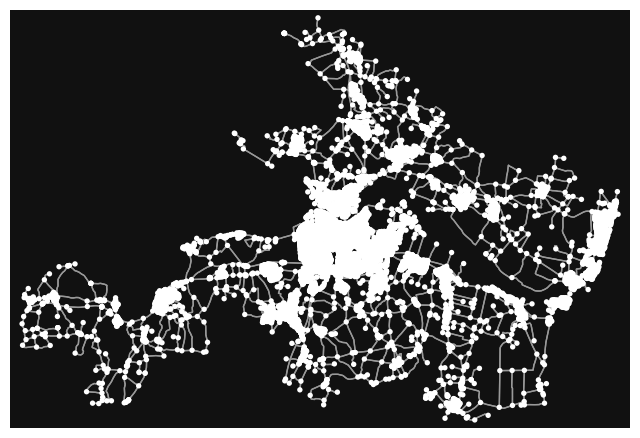

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [7]:
# plot the graph and colour some of the nodes
nc = ['r' if G.nodes[node]['proximity_to_school'] < 500 else 'b' for node in G.nodes()]

fig, ax = ox.plot_graph(G, node_color=nc, node_zorder=2, node_size=30, edge_color='gray', bgcolor='w')

# make it to directed

TypeError: '<' not supported between instances of 'str' and 'int'

In [ ]:
import pyproj

# Convert UTM32 to latitude and longitude (WGS 84)
utm_zone = 32  # UTM zone for your coordinates
proj_utm = pyproj.Proj(f'epsg:326{utm_zone}')  # EPSG code for UTM32N
proj_wgs = pyproj.Proj('epsg:4326')  # EPSG code for WGS 84

# Function to convert UTM to WGS84
def utm_to_wgs(row):
    lat, lon = pyproj.transform(proj_utm, proj_wgs, row['Xkoordinat'], row['Ykoordinat'])
    return pd.Series({'latitude': lat, 'longitude': lon})